# OIC-234 Analyzing area of EB cells

This project is in collaboration with Junwei Niu (Wen Lab). The goal is to identify "light" regions, which are indicative of differentiated cells, in each organoid. To determine "light" vs "dark", this code uses Otsu's method to pick a threshold. Alternatives could include using histogram percentiles.

In [1]:
# Import required packages
import numpy as np
from scipy import ndimage as ndi
import skimage
import os
import matplotlib.pyplot as plt
import csv

In [2]:
# Define function to generate overlay images
def imoverlay(image_A, image_B, color, plot_outlines=True, normalize=True):
    # Always assume that image_A is supposed to be an image
    # Image_B can be an image, binary mask, or label

    # if normalize:
    #     if image_A.ndims == 1:
    #         image_A = 
    #     for c in range(image_A)
    

    if plot_outlines and (image_B.ndim == 2):
        image_B = skimage.segmentation.find_boundaries(image_B)
    else:
        image_B = image_B > 0
    # plt.imshow(outlines)

    image_out = np.zeros((image_A.shape[0], image_A.shape[1], 3), np.uint8)

    for c in range(3):
        if image_A.ndim < 3:
            curr_slice = (image_A - np.min(image_A))/(np.max(image_A) - np.min(image_A)) * 255
        else:
            curr_slice = image_A[:, :, c]
            
        curr_slice[image_B] = color[c] * 255
        image_out[:, :, c] = curr_slice

    return image_out

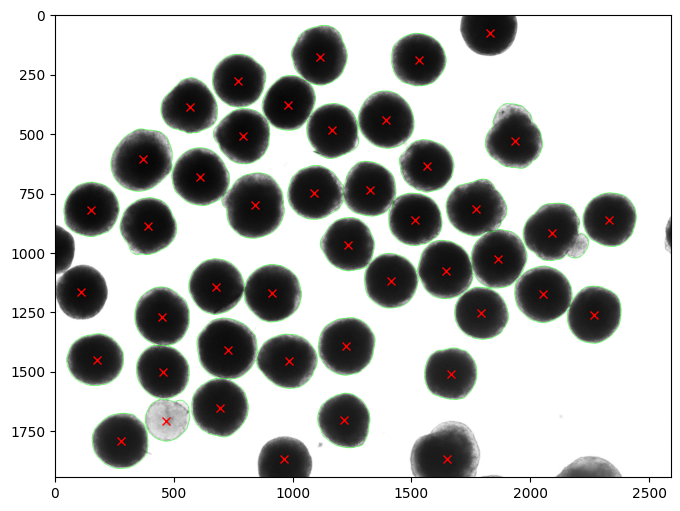

In [19]:
data_directory = '\\\\pn.vai.org\\projects\\wen\\vari-core-generated-data\\OIC\\OIC-234 EB Junwei\\EB8 image'

file = 'WT13-1 2X.tif'

image = skimage.io.imread(os.path.join(data_directory, file))
image = skimage.color.rgb2gray(image)

# Identify the EB cells
#thresh = skimage.filters.threshold_otsu(image)

#mask = image < (1.25 * thresh)

mask = image < 0.99

mask = skimage.morphology.binary_opening(mask, skimage.morphology.disk(30))
mask = skimage.morphology.remove_small_holes(mask, 200)

distance = ndi.distance_transform_edt(mask)
coords = skimage.feature.peak_local_max(distance, footprint=np.ones((3, 3)), labels=mask, threshold_abs=(0.5 * np.max(distance)), min_distance=75)
mask_marker = np.zeros(distance.shape, dtype=bool)
mask_marker[tuple(coords.T)] = True
markers, _ = ndi.label(mask_marker)
labels = skimage.segmentation.watershed(-distance, markers, mask=mask)

labels = skimage.segmentation.clear_border(labels)

labels = skimage.morphology.remove_small_objects(labels, 200)

ovimg = imoverlay(image, labels, [0, 1, 0])
# ovimg = overlay_mask(ovimg, markers, [1, 0, 0])

plt.figure(figsize=(8, 6))
plt.imshow(ovimg)
plt.plot(coords[:, 1], coords[:, 0], 'rx')

126.22159086305322


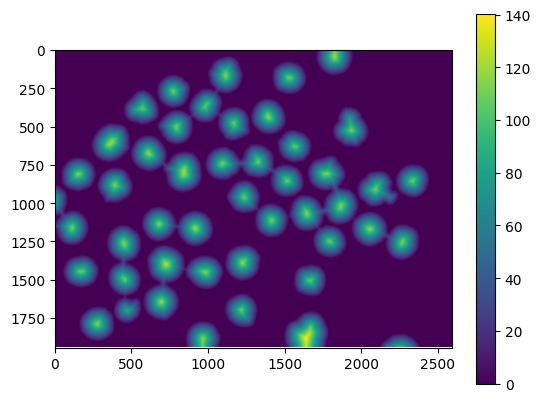

In [16]:
print(0.9 * np.max(distance))

plt.imshow(distance)
plt.colorbar()
#plt.plot(coords[:, 0], coords[:, 1], 'rx')

In [4]:
ovimg = overlay_mask(image, labels, [0, 1, 0])
ovimg = overlay_mask(ovimg, mask_marker, [1, 0, 0], plot_outlines=False)

#plt.figure(figsize=(8, 6))
plt.imshow(ovimg)
plt.plot(coords[:, 1], coords[:, 0], 'rx')


NameError: name 'overlay_mask' is not defined

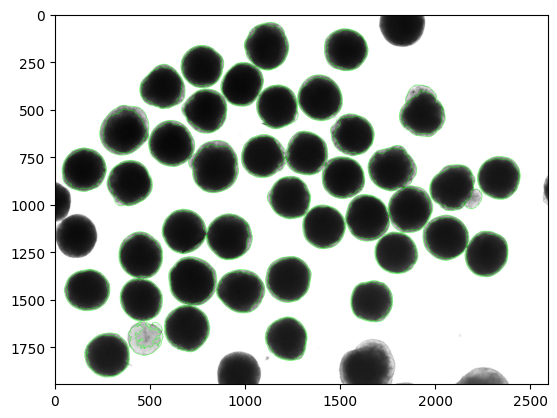

In [21]:
# For each cell, calculate a threshold which determines the lighter region

props = skimage.measure.regionprops(labels)

obj_labels = np.unique(labels)

inner_cell_labels = np.zeros(labels.shape, np.int32)

for obj in obj_labels:

    if obj == 0:
        continue
    else:
        intensities = image[labels == obj]

        # plt.figure()
        # plt.hist(intensities.ravel(), bins=30)
        thresh_cell = skimage.filters.threshold_otsu(intensities)

        curr_cell_label = np.zeros(labels.shape, np.bool)
        curr_cell_label[labels == obj] = True
        curr_cell_label[image < thresh_cell] = False

        curr_cell_label = skimage.morphology.remove_small_holes(curr_cell_label, 200)
        curr_cell_label = skimage.morphology.binary_opening(curr_cell_label, skimage.morphology.disk(2))

        inner_cell_labels[curr_cell_label] = obj
        
ovimg = imoverlay(image, inner_cell_labels, [0, 1, 0])
plt.imshow(ovimg)

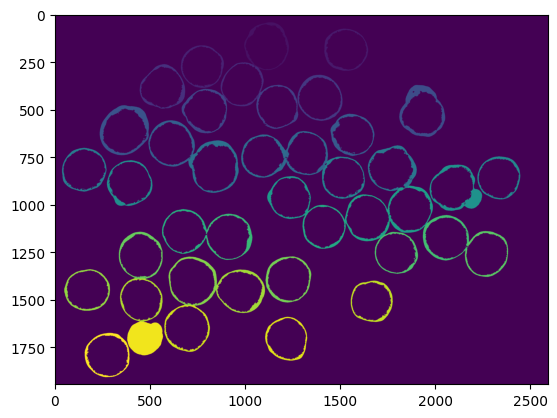

In [25]:
# Maybe do a global threshold instead?
intensities = image[labels > 0]

thresh_cell = skimage.filters.threshold_otsu(intensities)

inner_cell_mask = image >= thresh_cell

inner_cell_labels = labels.copy()
inner_cell_labels[~inner_cell_mask] = 0

plt.imshow(inner_cell_labels)



In [ ]:
props_inner = skimage.measure.regionprops(inner_cell_labels)

In [ ]:
#print(len(props))
#print(len(props_inner))

for p in props:
    print(p.area)

In [ ]:
# Make CSV
output_directory = "./test"

os.makedirs(output_directory, exist_ok=True)

with open(os.path.join(output_directory, "test.csv"), 'w', newline='') as file:

    writer = csv.writer(file, delimiter=",")   

    #Write CSV headers
    writer.writerow(["Cell", "Label", "Total area (px)", "Bright region area (px)", "Ratio (Bright/Total)"])

    ctr = 0
    for p in props:
        writer.writerow([ctr + 1, p.label, p.area, props_inner[ctr].area, props_inner[ctr].area/p.area])
        ctr += 1

    
